<a href="https://colab.research.google.com/github/egafdharmawan/Time-Series/blob/main/Time_Series_Analysis_Arima_VS_Auto_Arima_%5BHospital_Employee_Cali%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [ ]:
!pip install sktime[all_extras]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.arima import ARIMA

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import (
    temporal_train_test_split)
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import (
    mean_absolute_percentage_error)

import warnings
warnings.filterwarnings("ignore")

# Dataset

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/egafdharmawan/Dataset/main/California_Hospitality_Employees.csv")
data.head()

,Date,Employees
0,1/1/1990,1064.5
1,2/1/1990,1074.5
2,3/1/1990,1090.0
3,4/1/1990,1097.4
4,5/1/1990,1108.7


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       348 non-null    object 
 1   Employees  348 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.6+ KB


In [ ]:
data['Time'] = pd.to_datetime(data['Date'])
data['Employees'] = data['Employees'].astype('int')
data = data[['Time','Employees']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Time       348 non-null    datetime64[ns]
 1   Employees  348 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.6 KB


In [ ]:
data.head()

,Time,Employees
0,1990-01-01,1064
1,1990-02-01,1074
2,1990-03-01,1090
3,1990-04-01,1097
4,1990-05-01,1108


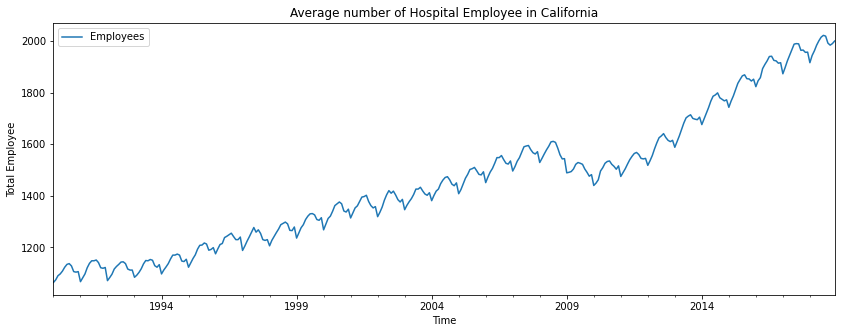

In [ ]:
# Plot The Data
data.plot(
    x = 'Time', 
    y = 'Employees',
    figsize = (14,5)
)
plt.title("Average number of Hospital Employee in California")
plt.ylabel("Total Employee")
plt.show()

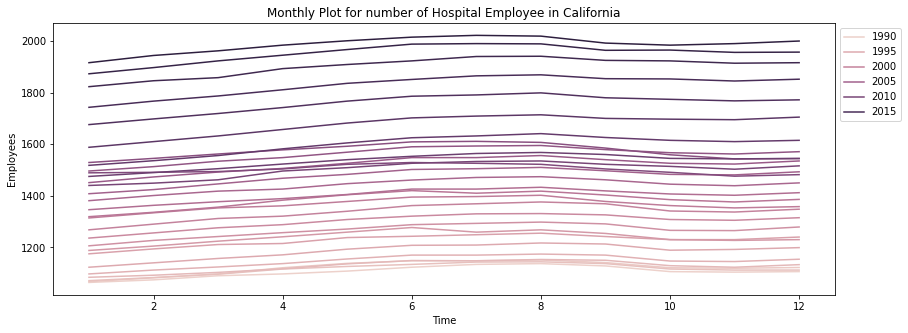

In [ ]:
# Plot the Data in monthly for each year

plt.figure(figsize=(14,5))
sns.lineplot(
    data = data,
    x = data.Time.dt.month,
    y = 'Employees',
    hue = data.Time.dt.year
)

plt.title("Monthly Plot for number of Hospital Employee in California")
plt.legend(bbox_to_anchor= (1,1))
plt.show()

# Dataset Diagnose

Dataset diagnose is a must in order to find the best ARIMA model.

### ACF & PACF Plot

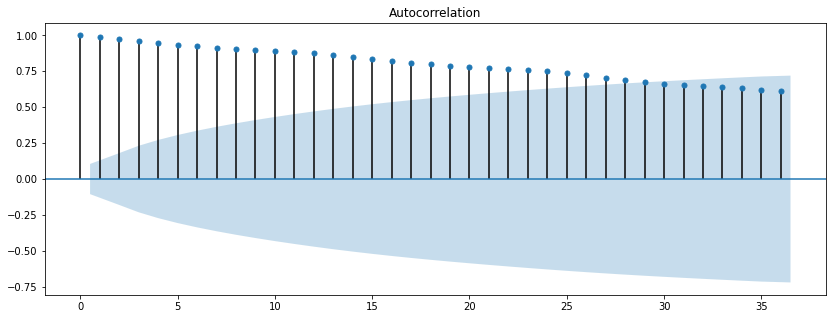

In [ ]:
 # Plot ACF

plot_acf(
    data['Employees'], 
    lags = 36
).set_size_inches((14,5));

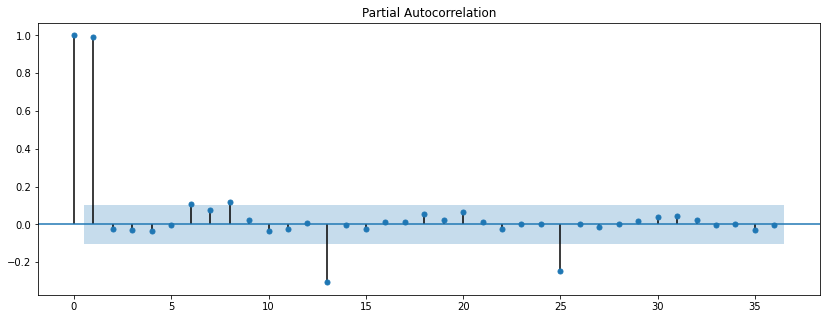

In [ ]:
# Plot PACF

plot_pacf(
    data['Employees'], 
    lags = 36
).set_size_inches((14,5));

Based on ACF and PACF plot, we know that ACF has a decay pattern, so it's a white noise, while PACF has lag 1, mean it is possible perform ARIMA without any transforming data with model AR-1.

### Decomposing

In [ ]:
monthly_data = data.set_index('Time')
monthly_data.index = pd.DatetimeIndex(monthly_data.index, freq = 'MS')

let's throw additive parameter since the variance of the data seem to be static.

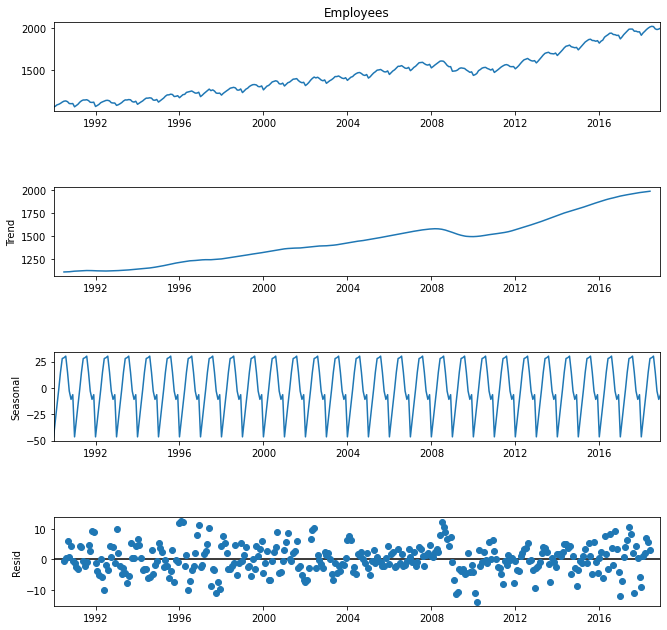

In [ ]:
decompose = sm.tsa.seasonal_decompose(
    monthly_data['Employees'], 
    model = 'additive'
)
decompose.plot().set_size_inches((10,10))

From this plot, there is seasonal happen every year (12 months), there is a trend, and the data seem to be non stationary since there is a down trend at 2010. This may distrub the model since ARIMA work better when the data is stationary.

Let's Conduct a few test to make sure if we need to perform differencing to the data.

### Unit Root Test

To make sure the data is stationary we can conduct unit root test. Let's use KPSS Test.

KPSS test Rules.
- **H0** : If p-value more than 5%, data is **stationary**
- **H1** : If p-value less than 5%, data is **non stationary**

In [ ]:
print("Results of KPSS Test:")
kpsstest = kpss(data['Employees'], lags="auto")
kpss_output = pd.Series(
    kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
)
for key, value in kpsstest[3].items():
    kpss_output["Critical Value (%s)" % key] = value
print(kpss_output)

Results of KPSS Test:
Test Statistic            2.8115
p-value                   0.0100
Lags Used                11.0000
Critical Value (10%)      0.3470
Critical Value (5%)       0.4630
Critical Value (2.5%)     0.5740
Critical Value (1%)       0.7390
dtype: float64


Since the value is more than 5% (which is 1%) mean we can **reject the null hipothesis** and confirm the **data is non stationary**.

# Data Transformation

Since the data is stationary, we need to perform differencing.

### DIfferencing

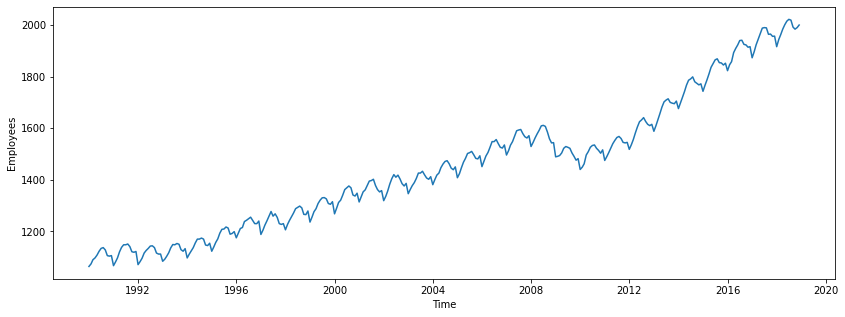

In [ ]:
# trend
plt.figure(figsize=(14,5))
sns.lineplot(
    x = data['Time'],
    y = data['Employees'],
    sizes = (14,5)
);

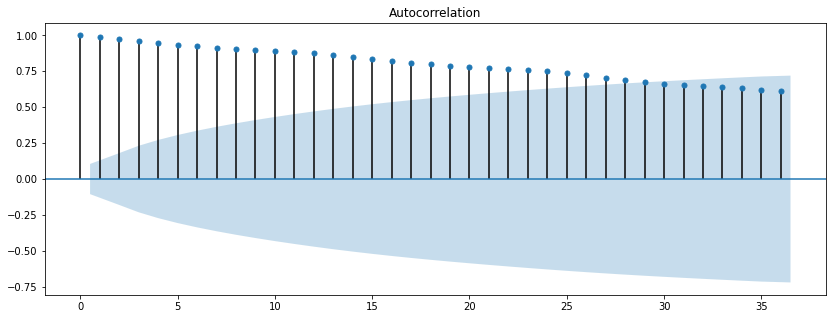

In [ ]:
# Normal Plot ACF
plot_acf(
    data['Employees'], 
    lags = 36
).set_size_inches((14,5));

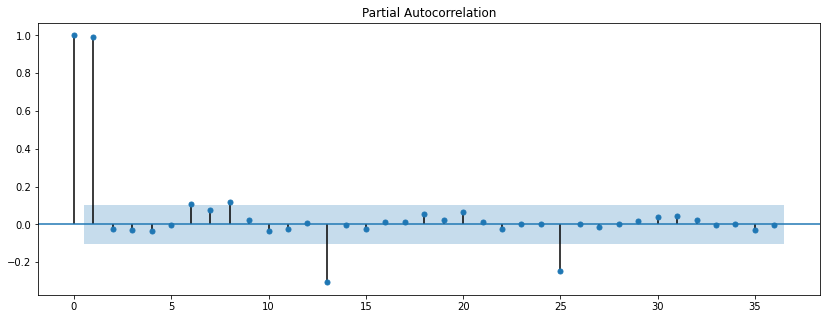

In [ ]:
# Normal Plot PACF
plot_pacf(
    data['Employees'], 
    lags = 36
).set_size_inches((14,5));

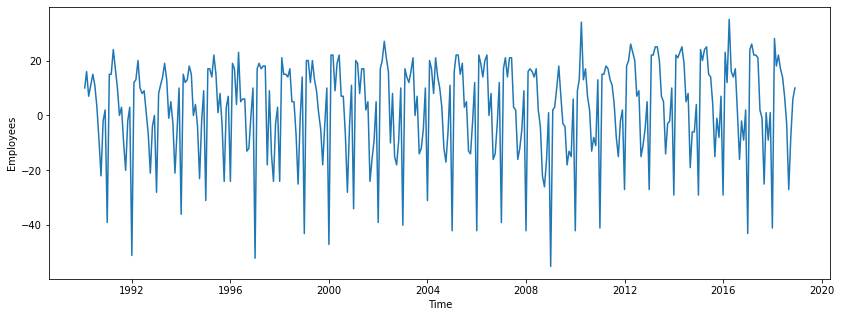

In [ ]:
# trend 1st differencing
plt.figure(figsize=(14,5))
sns.lineplot(
    x = data['Time'],
    y = data['Employees'].diff(),
    sizes = (14,5)
);

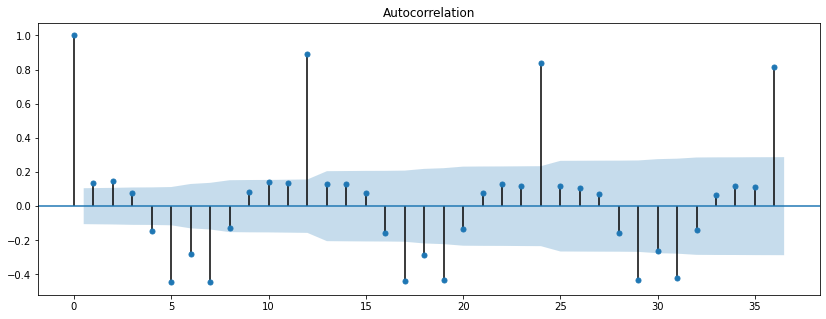

In [ ]:
# 1st Differencing Plot ACF
plot_acf(
    data['Employees'].diff().dropna(), 
    lags = 36
).set_size_inches((14,5));

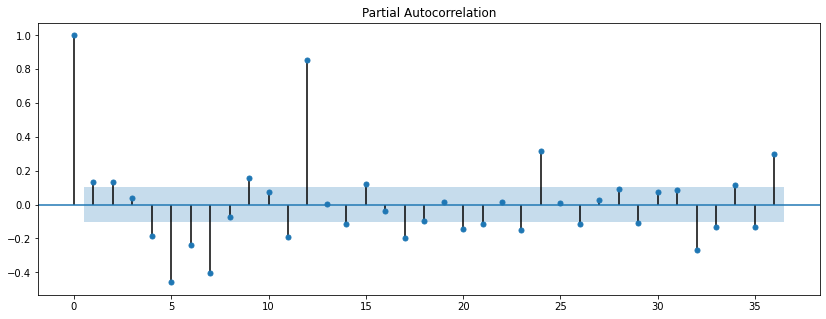

In [ ]:
# 1st Differencing Plot PACF
plot_pacf(
    data['Employees'].diff().dropna(), 
    lags = 36
).set_size_inches((14,5));

Before we move into modelling let's review the pattern before and after differencing. In ACF Plot we can conclude that ACF still form a pattern, but after difference, it has lag 2 is mean MA is either 0 or when diff is 1, we can use MA-2. On the other side, PACF before differencing looks pretty good with lag significance in 1, after differencing it is move to lag 2, we can use either AR-1 or AR-2 in this case.

# Modelling

In [ ]:
# set Date as index
data = data.set_index('Time')
data.index = pd.PeriodIndex(data.index, freq = 'M')

In [ ]:
# Do train-test split
y_train, y_test = temporal_train_test_split(data, test_size=50)

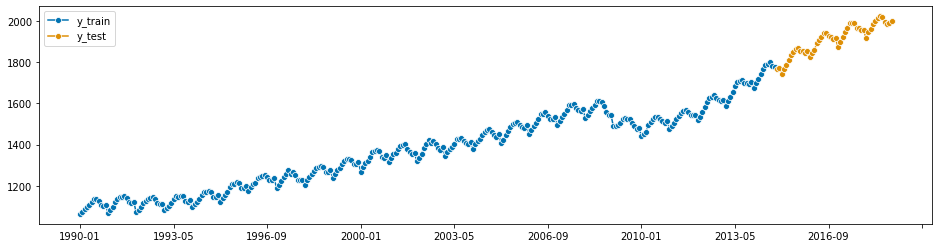

In [ ]:
# check the time series after splitting
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

In [ ]:
#specific data points
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2014-11', '2014-12', '2015-01', '2015-02', '2015-03', '2015-04',
             '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10',
             '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04',
             '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10',
             '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04',
             '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10',
             '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04',
             '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10',
             '2018-11', '2018-12'],
            dtype='period[M]', is_relative=False)

### ARIMA

Let's narrow the possibilities based on our analysis. We can use these combination, when diff is 0, possible order is AR-1, when diff is 1, possible order is AR-2, MA-2 or both. 

In [ ]:
order = ((1,0,0),(2,1,0),(0,1,2),(2,1,2))
season = ((1,0,0,12),(2,1,0,12),(0,1,2,12),(2,1,2,12))

In [ ]:
for x in order:
  for y in season:
    arima = ARIMA(
      order=x,
      seasonal_order=y,
      suppress_warnings=True)
    arima.fit(y_train)
    print(x,y, arima.get_fitted_params())

(1, 0, 0) (1, 0, 0, 12) {'intercept': 1.1637458785360633, 'ar.L1': 0.9902909051084839, 'ar.S.L12': 0.9209873370825795, 'sigma2': 46.77811292694264, 'aic': 2029.609676732833, 'aicc': 2029.746195504164, 'bic': 2044.3980506788546, 'hqic': 2035.529325773966}
(1, 0, 0) (2, 1, 0, 12) {'intercept': 0.32701728418828846, 'ar.L1': 0.993873683236888, 'ar.S.L12': -0.57990260141601, 'ar.S.L24': -0.2780682447404893, 'sigma2': 35.19358714737335, 'aic': 1848.883475670978, 'aicc': 1849.0977613852638, 'bic': 1867.1634347250772, 'hqic': 1856.2106304781616}
(1, 0, 0) (0, 1, 2, 12) {'intercept': 0.13494022748279738, 'ar.L1': 0.9951078136217727, 'ma.S.L12': -0.7262813299146452, 'ma.S.L24': -0.08187388695947351, 'sigma2': 31.795454185334577, 'aic': 1825.276975970189, 'aicc': 1825.4912616844747, 'bic': 1843.5569350242881, 'hqic': 1832.6041307773726}
(1, 0, 0) (2, 1, 2, 12) {'intercept': 0.24193792520430507, 'ar.L1': 0.9950435058974907, 'ar.S.L12': -0.8678381214929144, 'ar.S.L24': 0.09974571423202648, 'ma.S.L1

Model with the least AIC is model with order (2,1,2) and seasonal (0,1,2,12)

In [ ]:
arima = ARIMA(order=(2,1,2),
      seasonal_order=(0,1,2,12),
      suppress_warnings=True)
arima.fit(y_train)

ARIMA(order=(2, 1, 2), seasonal_order=(0, 1, 2, 12), suppress_warnings=True)

In [ ]:
y_pred_arima = arima.predict(fh=fh)

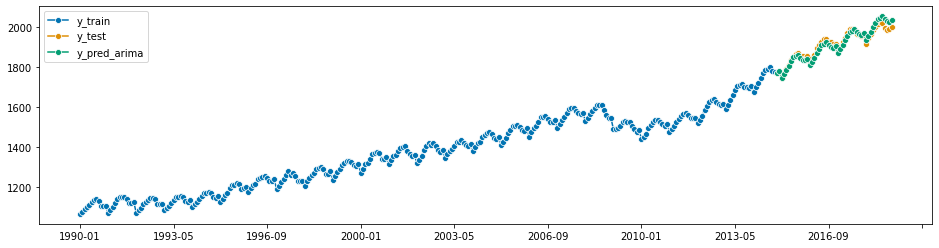

In [ ]:
# plot the forecast result
plot_series(y_train, y_test, y_pred_arima, labels=["y_train", "y_test", "y_pred_arima"]);

In [ ]:
arima.get_fitted_params()

{'intercept': 0.009352534647957354,
 'ar.L1': 1.2976064236302507,
 'ar.L2': -0.34762316345195815,
 'ma.L1': -1.3194394576303843,
 'ma.L2': 0.4608449391566802,
 'ma.S.L12': -0.8188544835053935,
 'ma.S.L24': 0.042619316106871315,
 'sigma2': 28.333242524843627,
 'aic': 1789.1007648517912,
 'aicc': 1789.622503982226,
 'bic': 1818.3206782939403,
 'hqic': 1800.814301028086}

In [ ]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  298
Model:             SARIMAX(2, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -886.550
Date:                            Sun, 04 Sep 2022   AIC                           1789.101
Time:                                    14:42:08   BIC                           1818.321
Sample:                                         0   HQIC                          1800.814
                                            - 298                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0094      0.012      0.772      0.440      -0.014       0.033
ar.L1          1.2976      0.360      3.600      0.000       0.591       2.004
ar.L2         -0.3476      0.342     -1.017      0.309      -1.018       0.322
ma.L1         -1.3194      0.331     -3.988      0.000      -1.968      -0.671
ma.L2          0.4608      0.280      1.644      0.100      -0.088       1.010
ma.S.L12      -0.8189      0.057    -14.312      0.000      -0.931      -0.707
ma.S.L24       0.0426      0.056      0.765      0.444      -0.067       0.152
sigma2        28.3332      1.867     15.177      0.000      24.674      31.992
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                74.06
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.16
Prob(H) (two-sided):                  0.21   Kurtosis:                         5.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
mean_absolute_percentage_error(y_test, y_pred_arima) * 100

0.776149997663564

### Auto Arima

Now let's leave all the work to auto arima.

In [ ]:
# define arima forecaster model
arima_forecaster = AutoARIMA(sp=12, suppress_warnings=True, random_state = 1000)

In [ ]:
# fit forecaster to train data
arima_forecaster.fit(y_train)

AutoARIMA(random_state=1000, sp=12, suppress_warnings=True)

In [ ]:
# do prediction based on forecast horizon we already defined
y_pred_auto_arima = arima_forecaster.predict(fh=fh)

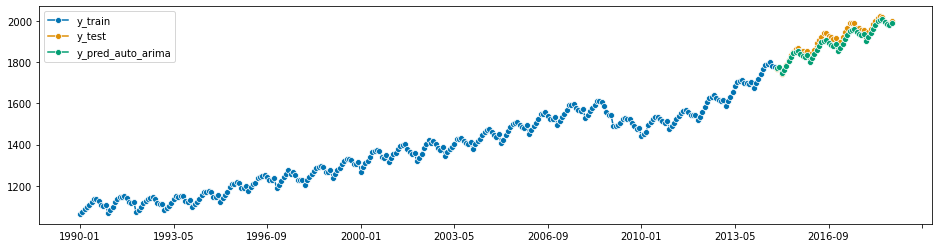

In [ ]:
# plot the forecast result
plot_series(y_train, y_test, y_pred_auto_arima, labels=["y_train", "y_test", "y_pred_auto_arima"]);

In [ ]:
arima_forecaster.get_fitted_params()

{'ar.L1': 0.7536601703814241,
 'ar.L2': 0.1583342430343438,
 'ma.L1': -0.7681545392559134,
 'ar.S.L12': 0.99788529582991,
 'ma.S.L12': -0.7860612926247477,
 'sigma2': 28.46360733093024,
 'order': (2, 1, 1),
 'seasonal_order': (1, 0, 1, 12),
 'aic': 1890.3605233845299,
 'aicc': 1890.6501785569437,
 'bic': 1912.5229162173462,
 'hqic': 1899.2329147249877}

In [ ]:
arima_forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  298
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -939.180
Date:                            Sun, 04 Sep 2022   AIC                           1890.361
Time:                                    13:46:03   BIC                           1912.523
Sample:                                         0   HQIC                          1899.233
                                            - 298                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7537      0.110      6.865      0.000       0.538       0.969
ar.L2          0.1583      0.075      2.120      0.034       0.012       0.305
ma.L1         -0.7682      0.086     -8.937      0.000      -0.937      -0.600
ar.S.L12       0.9979      0.001    828.528      0.000       0.996       1.000
ma.S.L12      -0.7861      0.048    -16.436      0.000      -0.880      -0.692
sigma2        28.4636      1.723     16.517      0.000      25.086      31.841
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                89.33
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.22
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
mean_absolute_percentage_error(y_test, y_pred_auto_arima) * 100

1.0769061567963878

### Comparison

Based on the result, we can see that our arima perform better with AIC 1789 while auto arima with AIC 1890. On error precentage ,arima also perform better than auto arima with error 0.77% while auto arima 1.07%. 

Here is how both fit the line.

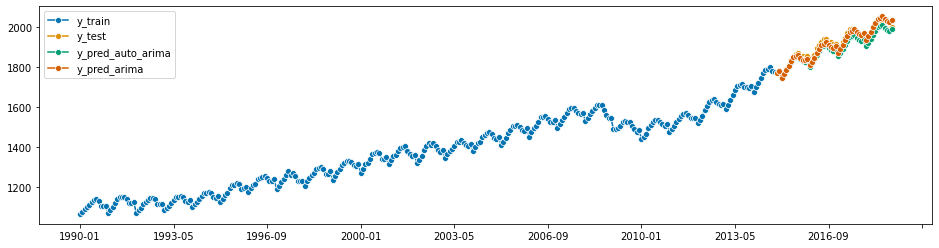

In [ ]:
plot_series(y_train, y_test, y_pred_auto_arima, y_pred_arima, 
            labels=["y_train", "y_test", "y_pred_auto_arima", "y_pred_arima"]);

# Model Diagnose

Diagnose the model is neccesary when we can't really trust the model.

### ARIMA

In [ ]:
# Check the residual
residuals = y_test - y_pred_arima

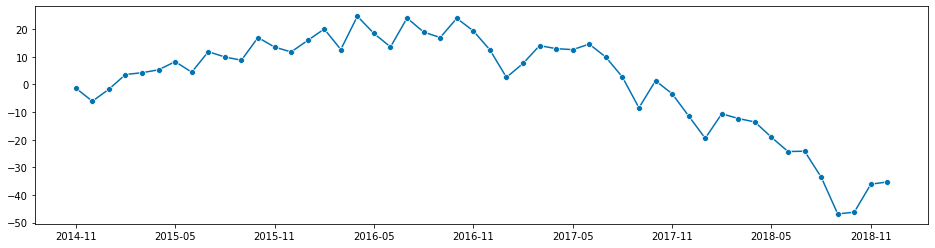

In [ ]:
plot_series(residuals);

The residual in ARIMA model somehow create a static pattern at first then start to forming a down trend.

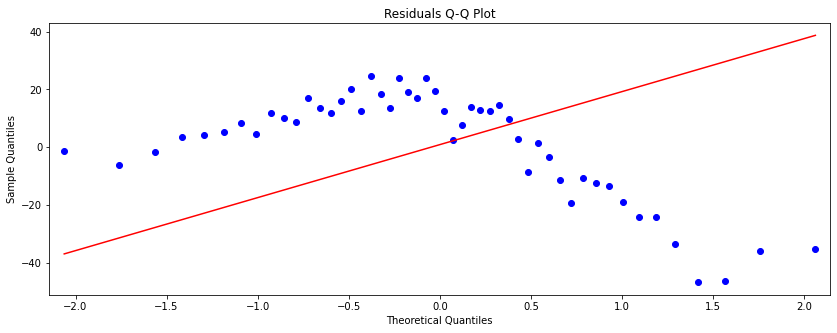

In [ ]:
sm.qqplot(residuals, line = 's').set_size_inches((14,5))
plt.title("Residuals Q-Q Plot")
plt.show()

The Q-Q plot is so terrible, the dot mostly are not aligned with the line.

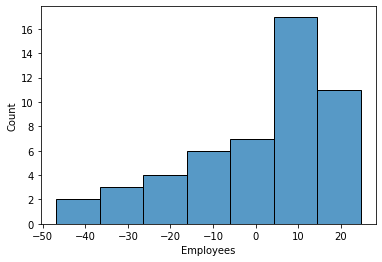

In [ ]:
sns.histplot(data = residuals, x = "Employees")

The distribution is right skewed

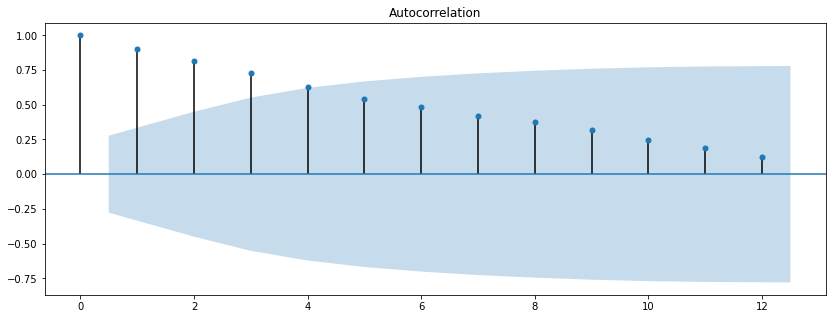

In [ ]:
# ACF plot
plot_acf(
    residuals, 
    lags = 12
).set_size_inches((14,5));

And the ACF plot of ARIMA still form a decay pattern.

### Auto ARIMA

In [ ]:
# Check the residual
residuals = y_test - y_pred_auto_arima

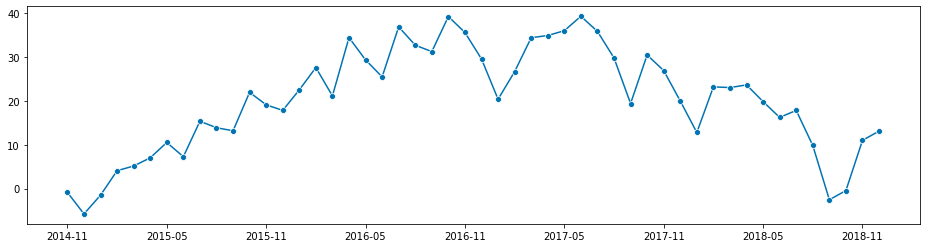

In [ ]:
plot_series(residuals);

The residual in AUTO ARIMA model seems to be better, more static (almost no trend) than the ARIMA model.

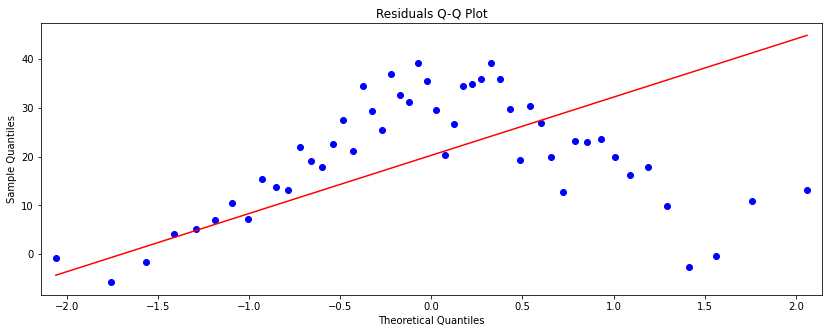

In [ ]:
sm.qqplot(residuals, line = 's').set_size_inches((14,5))
plt.title("Residuals Q-Q Plot")
plt.show()

The Q-Q plot also better since more dot are aligned with the line.

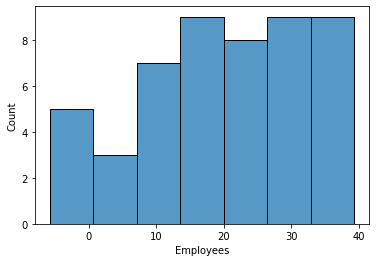

In [ ]:
sns.histplot(data = residuals, x = "Employees")

The distribution seem not to good, it is not distribute well enough.

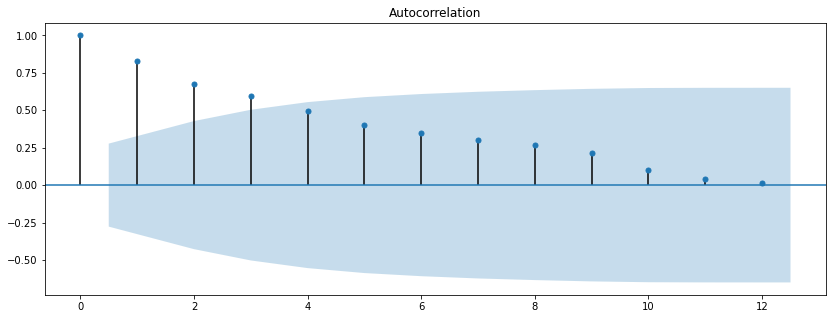

In [ ]:
# ACF plot
plot_acf(
    residuals, 
    lags = 12
).set_size_inches((14,5));

Also the ACF still has a decay pattern on it.

# Conclusion

**ARIMA VS AUTO ARIMA**

Based on model performance, ARIMA bested AUTO ARIMA in this case, by AIC score and by Error Precentage. Meanwhile in model reasoning / diagnose, Auto ARIMA seem like better model than ARIMA. The residual pattern in AUTO ARIMA does not form a trend, fit the residual line in Q-Q plot, and has (just a little) dot in under significance area in ACF Plot.

Based on Overall result, no model is eligible to be put on the production, we may need better model since arima can only perform better in stationary dataset.